In [2]:
# SIMPLEST APPROACH - Run this cell first
!pip install opendatasets pandas --quiet

import opendatasets as od
import pandas as pd

# Download the dataset (it will prompt for Kaggle credentials)
print("Downloading dataset...")
od.download("https://www.kaggle.com/datasets/bahushruth/legalclausedataset", "./legal_data")

print("Download complete! Files:")
import os
for file in os.listdir("./legal_data/legalclausedataset"):
    if file.endswith('.csv'):
        print(f"  - {file}")

# Now you can use the data path in your main code
DATA_PATH = "./legal_data/legalclausedataset"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Munieba09
Your Kaggle Key: ········
Dataset URL: https://www.kaggle.com/datasets/bahushruth/legalclausedataset


100%|██████████████████████████████████████████████████████████████████████████████| 19.4M/19.4M [00:00<00:00, 220MB/s]

Download complete! Files:
  - absence-of-certain-changes-or-events.csv
  - absence-of-certain-changes.csv
  - acceleration.csv
  - access-to-information.csv
  - access.csv
  - accounting-terms.csv
  - additional-agreements.csv
  - additional-documents.csv
  - adjustments.csv
  - affirmative-covenants.csv
  - agreement.csv
  - agreements.csv
  - amendment-and-waiver.csv
  - amendment-waiver.csv
  - amendment.csv
  - amendments-and-waivers.csv
  - amendments-etc.csv
  - amendments-waivers.csv
  - amendments.csv
  - applicable-law.csv
  - application-of-proceeds.csv
  - appointment.csv
  - approvals.csv
  - arbitration.csv
  - assignability.csv
  - assignment.csv
  - assignments.csv
  - attorneys-fees.csv
  - authority.csv
  - authorization.csv
  - auto_renewal.csv
  - background.csv
  - bank-accounts.csv
  - bankruptcy.csv
  - base-salary.csv
  - benefits.csv
  - bereavement-leave.csv
  - binding-effect.csv
  - bonus.csv
  - books-and-records.csv
  - brokerage.csv
  - brokers.csv
  - can

Using device: cpu
Epoch 1/50: Train Loss 0.7167, Train Acc 0.4955, Val Loss 0.6917, Val Acc 0.5267
Epoch 6/50: Train Loss 0.6964, Train Acc 0.4926, Val Loss 0.6956, Val Acc 0.4733
Early stopping at epoch 6
Epoch 1/50: Train Loss 0.7130, Train Acc 0.4985, Val Loss 0.6880, Val Acc 0.7333
Epoch 6/50: Train Loss 0.1630, Train Acc 0.9658, Val Loss 0.3083, Val Acc 0.8800
Epoch 11/50: Train Loss 0.0269, Train Acc 0.9985, Val Loss 0.5060, Val Acc 0.8533
Early stopping at epoch 11
BiLSTM Metrics: {'accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.6741333333333334, 'pr_auc': 0.7021225528509333}
CNN Metrics: {'accuracy': 0.86, 'precision': 0.8648648648648649, 'recall': 0.8533333333333334, 'f1_score': 0.8590604026845637, 'roc_auc': 0.9427555555555556, 'pr_auc': 0.9489598768595461}


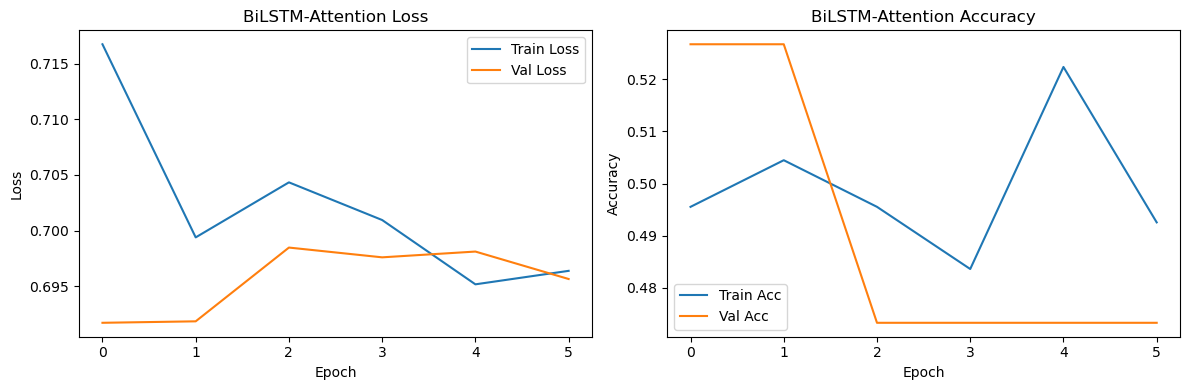

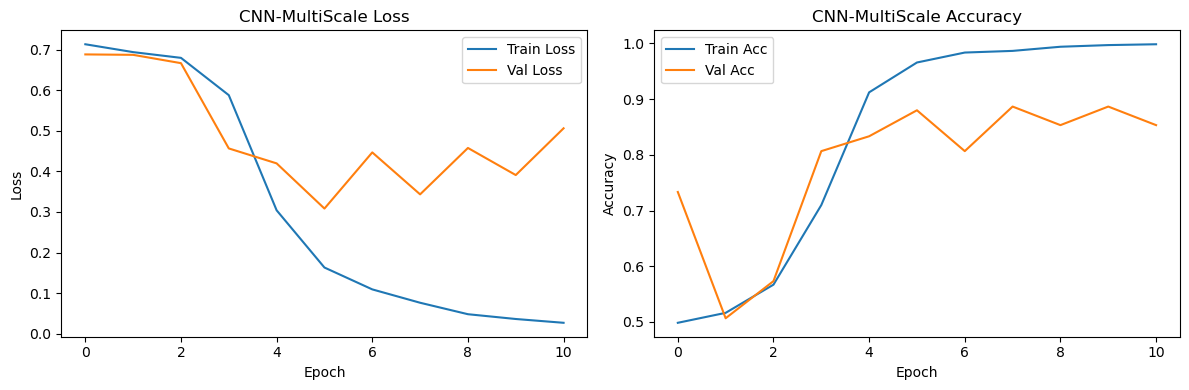

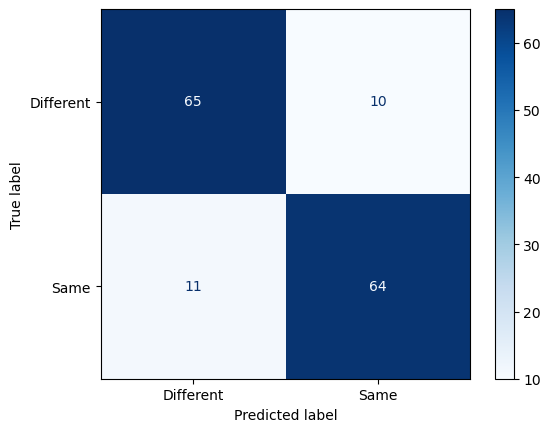

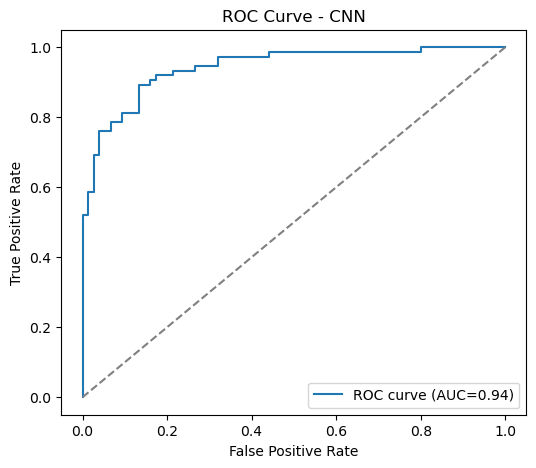

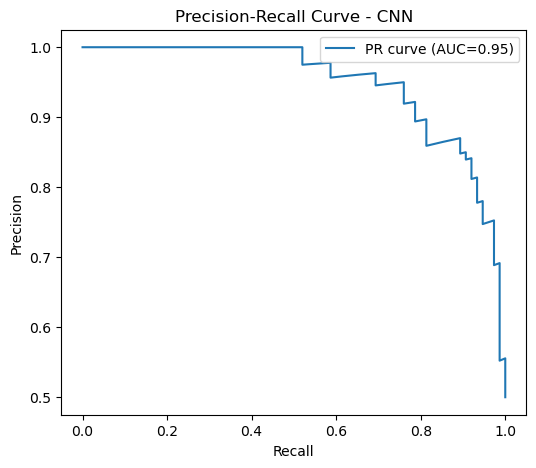

In [20]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== Dataset and Tokenizer ====================
class LegalClauseDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=200):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        clause1, clause2, label = self.pairs[idx]
        tokens1 = self.tokenizer.text_to_sequence(clause1)
        tokens2 = self.tokenizer.text_to_sequence(clause2)
        return {
            'clause1': torch.tensor(tokens1, dtype=torch.long),
            'clause2': torch.tensor(tokens2, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.float)
        }

class Tokenizer:
    def __init__(self, max_vocab_size=20000):
        self.vocab = {'<PAD>':0, '<UNK>':1}
        self.reverse_vocab = {0:'<PAD>',1:'<UNK>'}
        self.max_vocab_size = max_vocab_size
        self.vocab_size = 2
        
    def fit(self, texts):
        word_counts = Counter()
        for text in texts:
            tokens = self._tokenize(text)
            word_counts.update(tokens)
        for word, _ in word_counts.most_common(self.max_vocab_size-2):
            self.vocab[word] = self.vocab_size
            self.reverse_vocab[self.vocab_size] = word
            self.vocab_size +=1
    
    def _tokenize(self, text):
        if not isinstance(text,str):
            return []
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s.,;:!?()]','',text)
        return text.split()
    
    def text_to_sequence(self, text):
        tokens = self._tokenize(text)
        sequence = [self.vocab.get(tok,self.vocab['<UNK>']) for tok in tokens]
        return sequence[:200]

def collate_fn(batch):
    clause1 = [item['clause1'] for item in batch]
    clause2 = [item['clause2'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    clause1_padded = pad_sequence(clause1, batch_first=True, padding_value=0)
    clause2_padded = pad_sequence(clause2, batch_first=True, padding_value=0)
    return clause1_padded, clause2_padded, labels

# ==================== Models ====================
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention,self).__init__()
        self.hidden_dim = hidden_dim
        self.att_weights = nn.Parameter(torch.Tensor(hidden_dim,1))
        nn.init.xavier_uniform_(self.att_weights)
    def forward(self,x):
        att_scores = torch.matmul(x,self.att_weights).squeeze(-1)
        att_weights = F.softmax(att_scores,dim=1).unsqueeze(-1)
        return x*att_weights

class BiLSTMAttentionModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim=100,hidden_dim=64,max_length=200):
        super(BiLSTMAttentionModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,bidirectional=True,dropout=0.2)
        self.attention = SelfAttention(hidden_dim*2)
        self.fc1 = nn.Linear(hidden_dim*8,128)
        self.fc2 = nn.Linear(128,64)
        self.output = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.3)
        self.layernorm1 = nn.LayerNorm(128)
        self.layernorm2 = nn.LayerNorm(64)
        
    def forward(self, clause1, clause2):
        emb1 = self.embedding(clause1)
        lstm_out1,_ = self.bilstm(emb1)
        attn_out1 = self.attention(lstm_out1)
        encoded1 = torch.mean(attn_out1,dim=1)
        
        emb2 = self.embedding(clause2)
        lstm_out2,_ = self.bilstm(emb2)
        attn_out2 = self.attention(lstm_out2)
        encoded2 = torch.mean(attn_out2,dim=1)
        
        abs_diff = torch.abs(encoded1 - encoded2)
        multiplied = encoded1 * encoded2
        combined = torch.cat([encoded1, encoded2, abs_diff, multiplied],dim=1)
        
        x = F.relu(self.layernorm1(self.fc1(combined)))
        x = self.dropout(x)
        x = F.relu(self.layernorm2(self.fc2(x)))
        x = self.dropout(x)
        output = torch.sigmoid(self.output(x))
        return output.squeeze()

class CNNMultiScaleModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim=100,max_length=200):
        super(CNNMultiScaleModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.conv1 = nn.Conv1d(embedding_dim,64,2,padding=1)
        self.conv2 = nn.Conv1d(embedding_dim,64,3,padding=1)
        self.conv3 = nn.Conv1d(embedding_dim,64,4,padding=2)
        self.conv4 = nn.Conv1d(embedding_dim,64,5,padding=2)
        self.fc1 = nn.Linear(1024,128)
        self.fc2 = nn.Linear(128,64)
        self.output = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.4)
        self.layernorm1 = nn.LayerNorm(128)
        self.layernorm2 = nn.LayerNorm(64)
        
    def forward(self, clause1, clause2):
        def cnn_encoder(x):
            emb = self.embedding(x).transpose(1,2)
            pool_list = []
            for conv in [self.conv1,self.conv2,self.conv3,self.conv4]:
                conv_out = F.relu(conv(emb))
                pool = F.adaptive_max_pool1d(conv_out,1).squeeze(-1)
                pool_list.append(pool)
            return torch.cat(pool_list,dim=1)
        
        encoded1 = cnn_encoder(clause1)
        encoded2 = cnn_encoder(clause2)
        abs_diff = torch.abs(encoded1 - encoded2)
        multiplied = encoded1 * encoded2
        combined = torch.cat([encoded1, encoded2, abs_diff, multiplied],dim=1)
        
        x = F.relu(self.layernorm1(self.fc1(combined)))
        x = self.dropout(x)
        x = F.relu(self.layernorm2(self.fc2(x)))
        x = self.dropout(x)
        output = torch.sigmoid(self.output(x))
        return output.squeeze()

# ==================== Trainer ====================
class LegalClauseTrainer:
    def __init__(self, model, model_name, device):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.history = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
        
    def train(self, train_loader, val_loader, epochs=50, lr=0.001):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(),lr=lr,weight_decay=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss,train_correct,train_total = 0.0,0,0
            for clause1, clause2, labels in train_loader:
                clause1, clause2, labels = clause1.to(self.device), clause2.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(clause1, clause2)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0)
                optimizer.step()
                train_loss += loss.item()
                preds = (outputs>0.5).float()
                train_correct += (preds==labels).sum().item()
                train_total += labels.size(0)
            self.model.eval()
            val_loss,val_correct,val_total = 0.0,0,0
            with torch.no_grad():
                for clause1, clause2, labels in val_loader:
                    clause1, clause2, labels = clause1.to(self.device), clause2.to(self.device), labels.to(self.device)
                    outputs = self.model(clause1, clause2)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = (outputs>0.5).float()
                    val_correct += (preds==labels).sum().item()
                    val_total += labels.size(0)
            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)
            train_acc = train_correct/train_total if train_total>0 else 0
            val_acc = val_correct/val_total if val_total>0 else 0
            self.history['train_loss'].append(avg_train_loss)
            self.history['val_loss'].append(avg_val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            scheduler.step(avg_val_loss)
            if avg_val_loss<best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter=0
                torch.save(self.model.state_dict(), f'best_{self.model_name}.pth')
            else:
                patience_counter+=1
            if epoch%5==0 or epoch==epochs-1:
                print(f"Epoch {epoch+1}/{epochs}: Train Loss {avg_train_loss:.4f}, Train Acc {train_acc:.4f}, Val Loss {avg_val_loss:.4f}, Val Acc {val_acc:.4f}")
            if patience_counter>=patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        if os.path.exists(f'best_{self.model_name}.pth'):
            self.model.load_state_dict(torch.load(f'best_{self.model_name}.pth'))
        return self.history
    
    def evaluate(self,test_loader):
        self.model.eval()
        all_preds,all_probs,all_labels=[],[],[]
        with torch.no_grad():
            for clause1, clause2, labels in test_loader:
                clause1, clause2, labels = clause1.to(self.device), clause2.to(self.device), labels.to(self.device)
                outputs = self.model(clause1, clause2)
                probs = outputs.cpu().numpy()
                preds = (outputs>0.5).float().cpu().numpy()
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
        metrics = {
            'accuracy':accuracy_score(all_labels,all_preds),
            'precision':precision_score(all_labels,all_preds,zero_division=0),
            'recall':recall_score(all_labels,all_preds,zero_division=0),
            'f1_score':f1_score(all_labels,all_preds,zero_division=0),
            'roc_auc':roc_auc_score(all_labels,all_probs),
            'pr_auc':average_precision_score(all_labels,all_probs)
        }
        return metrics, all_probs, all_preds
    
    def plot_training_history(self):
        if len(self.history['train_loss'])==0:
            print("No training history available")
            return
        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
        ax1.plot(self.history['train_loss'],label='Train Loss')
        ax1.plot(self.history['val_loss'],label='Val Loss')
        ax1.set_title(f'{self.model_name} Loss')
        ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()
        ax2.plot(self.history['train_acc'],label='Train Acc')
        ax2.plot(self.history['val_acc'],label='Val Acc')
        ax2.set_title(f'{self.model_name} Accuracy')
        ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend()
        plt.tight_layout(); plt.show()

# ==================== Real Data Loader ====================
class RealLegalDataLoader:
    def __init__(self,data_path,max_sequence_length=200,max_vocab_size=20000):
        self.data_path=data_path
        self.max_sequence_length=max_sequence_length
        self.max_vocab_size=max_vocab_size
        self.tokenizer = Tokenizer(max_vocab_size)
        self.clauses_by_category = {}
        
    def load_and_preprocess_data(self):
        data_dir=os.path.join(self.data_path,"legalclausedataset")
        csv_files=[f for f in os.listdir(data_dir) if f.endswith('.csv')]
        total_clauses=0
        for csv_file in csv_files[:50]:
            category = csv_file.replace('.csv','')
            file_path=os.path.join(data_dir,csv_file)
            try:
                df = pd.read_csv(file_path)
                text_column = None
                for col in df.columns:
                    if 'text' in col.lower() or 'clause' in col.lower():
                        text_column=col; break
                if text_column is None and len(df.columns)>0:
                    text_column=df.columns[0]
                if text_column:
                    clauses = [str(t).strip() for t in df[text_column].dropna() if len(str(t).strip())>10]
                    if clauses:
                        self.clauses_by_category[category]=clauses
                        total_clauses+=len(clauses)
            except Exception as e:
                print(f"Error loading {csv_file}: {e}")
        pairs = self._create_training_pairs()
        return pairs
    
    def _create_training_pairs(self):
        pairs=[]
        categories=list(self.clauses_by_category.keys())
        positive_count,negative_count=0,0
        for category, clauses in self.clauses_by_category.items():
            if len(clauses)>=2:
                for i in range(min(len(clauses),5)):
                    for j in range(i+1,min(i+3,len(clauses))):
                        pairs.append((clauses[i],clauses[j],1))
                        positive_count+=1
        target_negatives=positive_count
        for i in range(target_negatives):
            cat1,cat2=np.random.choice(categories,2,replace=False)
            if (cat1 in self.clauses_by_category and cat2 in self.clauses_by_category and len(self.clauses_by_category[cat1])>0 and len(self.clauses_by_category[cat2])>0):
                clause1=np.random.choice(self.clauses_by_category[cat1])
                clause2=np.random.choice(self.clauses_by_category[cat2])
                pairs.append((clause1,clause2,0))
                negative_count+=1
        np.random.shuffle(pairs)
        return pairs

# ==================== Main Execution ====================
def main():
    DATA_PATH = "./legal_data"
    BATCH_SIZE = 32
    EPOCHS = 50
    EMBEDDING_DIM = 100
    MAX_LENGTH = 200
    MAX_VOCAB_SIZE = 20000
    
    torch.manual_seed(42); np.random.seed(42)
    if torch.cuda.is_available(): torch.cuda.manual_seed(42)
    
    data_loader = RealLegalDataLoader(DATA_PATH, MAX_LENGTH, MAX_VOCAB_SIZE)
    pairs = data_loader.load_and_preprocess_data()
    if not pairs: print("No data loaded!"); return
    
    all_texts = [p[0] for p in pairs]+[p[1] for p in pairs]
    data_loader.tokenizer.fit(all_texts)
    
    dataset = LegalClauseDataset(pairs, data_loader.tokenizer, MAX_LENGTH)
    train_size = int(0.7*len(dataset)); val_size=int(0.15*len(dataset)); test_size=len(dataset)-train_size-val_size
    train_dataset,val_dataset,test_dataset = torch.utils.data.random_split(dataset,[train_size,val_size,test_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,drop_last=True)
    val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,drop_last=False)
    test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,drop_last=False)
    
    # BiLSTM-Attention
    bilstm_model = BiLSTMAttentionModel(data_loader.tokenizer.vocab_size,EMBEDDING_DIM,MAX_LENGTH)
    bilstm_trainer = LegalClauseTrainer(bilstm_model,"BiLSTM-Attention",device)
    bilstm_history = bilstm_trainer.train(train_loader,val_loader,epochs=EPOCHS)
    
    # CNN Multi-scale
    cnn_model = CNNMultiScaleModel(data_loader.tokenizer.vocab_size,EMBEDDING_DIM,MAX_LENGTH)
    cnn_trainer = LegalClauseTrainer(cnn_model,"CNN-MultiScale",device)
    cnn_history = cnn_trainer.train(train_loader,val_loader,epochs=EPOCHS)
    
    # Evaluate
    bilstm_metrics, bilstm_probs, bilstm_preds = bilstm_trainer.evaluate(test_loader)
    cnn_metrics, cnn_probs, cnn_preds = cnn_trainer.evaluate(test_loader)
    
    # Save global outputs for visualization
    global bilstm_all_labels, bilstm_all_preds, bilstm_all_probs
    global cnn_all_labels, cnn_all_preds, cnn_all_probs, test_dataset_full
    test_dataset_full = list(test_dataset)
    bilstm_all_labels = np.array([s['label'].item() for s in test_dataset_full])
    bilstm_all_preds = np.array(bilstm_preds)
    bilstm_all_probs = np.array(bilstm_probs)
    cnn_all_labels = np.array([s['label'].item() for s in test_dataset_full])
    cnn_all_preds = np.array(cnn_preds)
    cnn_all_probs = np.array(cnn_probs)
    
    print("BiLSTM Metrics:", bilstm_metrics)
    print("CNN Metrics:", cnn_metrics)
    
    bilstm_trainer.plot_training_history()
    cnn_trainer.plot_training_history()

if __name__=="__main__":
    main()

# ==================== Visualization Example ====================
# Confusion Matrix
cm = confusion_matrix(cnn_all_labels, cnn_all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Different','Same'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# ROC Curve
fpr,tpr,_ = roc_curve(cnn_all_labels, cnn_all_probs)
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve - CNN'); plt.legend(); plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(cnn_all_labels, cnn_all_probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision,label=f'PR curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve - CNN'); plt.legend(); plt.show()


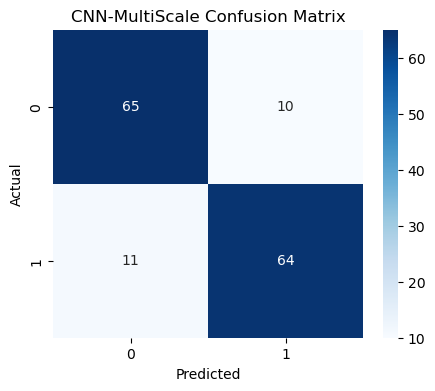

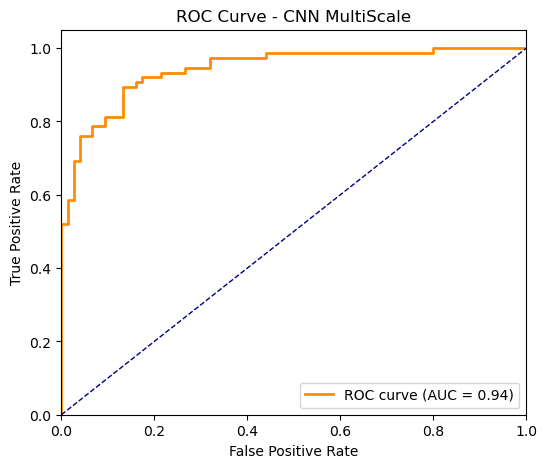

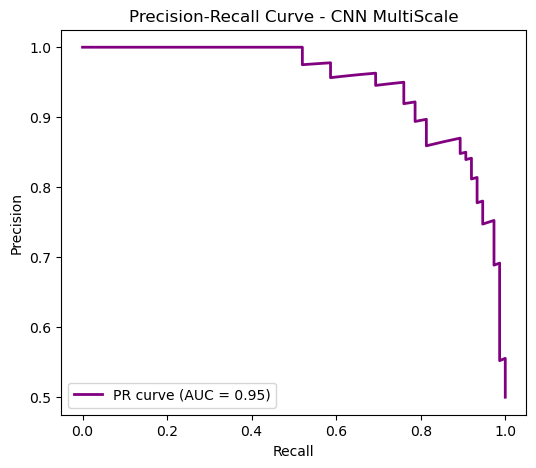


Sample Predictions:
--------------------------------------------------
Sample 1: True Label = 1.0, Pred = 1.0, Prob = 0.9155
Sample 2: True Label = 0.0, Pred = 0.0, Prob = 0.0582
Sample 3: True Label = 0.0, Pred = 1.0, Prob = 0.9378
Sample 4: True Label = 1.0, Pred = 1.0, Prob = 0.9464
Sample 5: True Label = 1.0, Pred = 1.0, Prob = 0.9474


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Make sure these are from your evaluation
# cnn_all_labels = all true labels (numpy array)
# cnn_all_preds = predicted labels (numpy array, 0/1)
# cnn_all_probs = predicted probabilities for positive class (numpy array)

# -----------------------------
# 1️⃣ Confusion Matrix
# -----------------------------
cm = confusion_matrix(cnn_all_labels, cnn_all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("CNN-MultiScale Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -----------------------------
# 2️⃣ ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(cnn_all_labels, cnn_all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN MultiScale')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 3️⃣ Precision-Recall Curve
# -----------------------------
precision, recall, thresholds_pr = precision_recall_curve(cnn_all_labels, cnn_all_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CNN MultiScale')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# 4️⃣ Sample Predictions
# -----------------------------
print("\nSample Predictions:\n" + "-"*50)
for i in range(min(5, len(cnn_all_labels))):
    print(f"Sample {i+1}: True Label = {cnn_all_labels[i]}, Pred = {cnn_all_preds[i]}, Prob = {cnn_all_probs[i]:.4f}")


In [23]:
def main():
    """Main execution function with real dataset"""
    global bilstm_metrics, bilstm_probs, bilstm_preds
    global cnn_metrics, cnn_probs, cnn_preds
    global all_labels

    # Configuration
    DATA_PATH = "./legal_data"  # Path where you downloaded the dataset
    BATCH_SIZE = 32
    EPOCHS = 50
    EMBEDDING_DIM = 100
    MAX_LENGTH = 200
    MAX_VOCAB_SIZE = 20000

    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    print("=== LEGAL CLAUSE SIMILARITY DETECTION WITH REAL DATASET ===")
    print(f"Using device: {device}")

    # Load real data
    data_loader = RealLegalDataLoader(DATA_PATH, MAX_LENGTH, MAX_VOCAB_SIZE)
    pairs = data_loader.load_and_preprocess_data()

    if not pairs:
        print("No data loaded! Check the dataset path.")
        return

    # Prepare tokenizer
    all_texts = [pair[0] for pair in pairs] + [pair[1] for pair in pairs]
    data_loader.tokenizer.fit(all_texts)

    # Create dataset
    dataset = LegalClauseDataset(pairs, data_loader.tokenizer, MAX_LENGTH)

    # Split data
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=collate_fn, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            collate_fn=collate_fn, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             collate_fn=collate_fn, drop_last=False)

    print(f"\nDataset split:")
    print(f"  Training: {len(train_dataset)} pairs")
    print(f"  Validation: {len(val_dataset)} pairs")
    print(f"  Test: {len(test_dataset)} pairs")
    print(f"  Vocabulary size: {data_loader.tokenizer.vocab_size}")

    # --------------------
    # BiLSTM with Attention
    # --------------------
    print("\n" + "="*60)
    print("TRAINING BiLSTM WITH ATTENTION MODEL")
    print("="*60)

    bilstm_model = BiLSTMAttentionModel(
        vocab_size=data_loader.tokenizer.vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_LENGTH
    )

    bilstm_trainer = LegalClauseTrainer(bilstm_model, "BiLSTM-Attention", device)
    bilstm_history = bilstm_trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # --------------------
    # CNN Multi-scale Model
    # --------------------
    print("\n" + "="*60)
    print("TRAINING CNN MULTI-SCALE MODEL")
    print("="*60)

    cnn_model = CNNMultiScaleModel(
        vocab_size=data_loader.tokenizer.vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_LENGTH
    )

    cnn_trainer = LegalClauseTrainer(cnn_model, "CNN-MultiScale", device)
    cnn_history = cnn_trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # --------------------
    # Evaluate models
    # --------------------
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    bilstm_metrics, bilstm_probs, bilstm_preds = bilstm_trainer.evaluate(test_loader)
    cnn_metrics, cnn_probs, cnn_preds = cnn_trainer.evaluate(test_loader)

    # Store true labels for table/plots
    all_labels = [label for _, _, label in test_dataset]

    # --------------------
    # Training history plots
    # --------------------
    print("\n" + "="*60)
    print("TRAINING HISTORY")
    print("="*60)
    bilstm_trainer.plot_training_history()
    cnn_trainer.plot_training_history()

    # --------------------
    # Sample predictions
    # --------------------
    print("\n" + "="*60)
    print("SAMPLE TEST PREDICTIONS (BiLSTM)")
    print("="*60)

    test_dataset_full = list(test_dataset)
    for i in range(min(5, len(test_dataset_full))):
        sample = test_dataset_full[i]
        clause1_tokens = sample['clause1'].numpy()
        clause2_tokens = sample['clause2'].numpy()
        true_label = sample['label'].item()

        clause1_text = ' '.join([data_loader.tokenizer.reverse_vocab.get(tok, '<UNK>')
                                 for tok in clause1_tokens if tok != 0])
        clause2_text = ' '.join([data_loader.tokenizer.reverse_vocab.get(tok, '<UNK>')
                                 for tok in clause2_tokens if tok != 0])

        pred_prob = bilstm_probs[i] if i < len(bilstm_probs) else 0
        pred_label = bilstm_preds[i] if i < len(bilstm_preds) else 0

        print(f"\nSample {i+1}:")
        print(f"Clause 1: {clause1_text[:100]}...")
        print(f"Clause 2: {clause2_text[:100]}...")
        print(f"True Label: {true_label}, Predicted: {pred_label}, Confidence: {pred_prob:.4f}")
        print(f"Status: {'CORRECT' if pred_label == true_label else 'INCORRECT'}")
        print("-" * 60)

    print("\nAll metrics and predictions are now available as global variables for tables/plots.")


=== LEGAL CLAUSE SIMILARITY DETECTION WITH REAL DATASET ===
Using device: cpu

Dataset split:
  Training: 700 pairs
  Validation: 150 pairs
  Test: 150 pairs
  Vocabulary size: 7375

TRAINING BiLSTM WITH ATTENTION MODEL
Epoch 1/50: Train Loss 0.6961, Train Acc 0.5179, Val Loss 0.6920, Val Acc 0.5267
Epoch 6/50: Train Loss 0.6988, Train Acc 0.4583, Val Loss 0.6930, Val Acc 0.5267
Early stopping at epoch 8

TRAINING CNN MULTI-SCALE MODEL
Epoch 1/50: Train Loss 0.7003, Train Acc 0.5536, Val Loss 0.6920, Val Acc 0.4800
Epoch 6/50: Train Loss 0.1301, Train Acc 0.9792, Val Loss 0.3815, Val Acc 0.8533
Early stopping at epoch 10

MODEL EVALUATION

TRAINING HISTORY


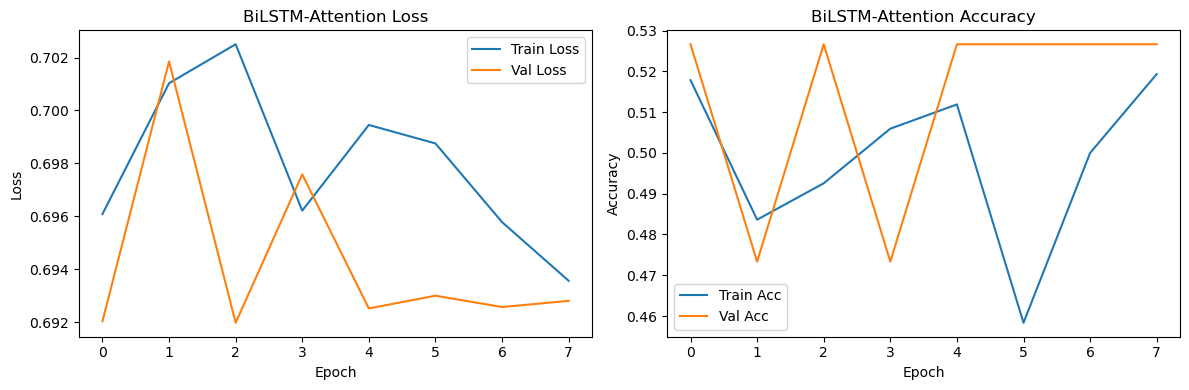

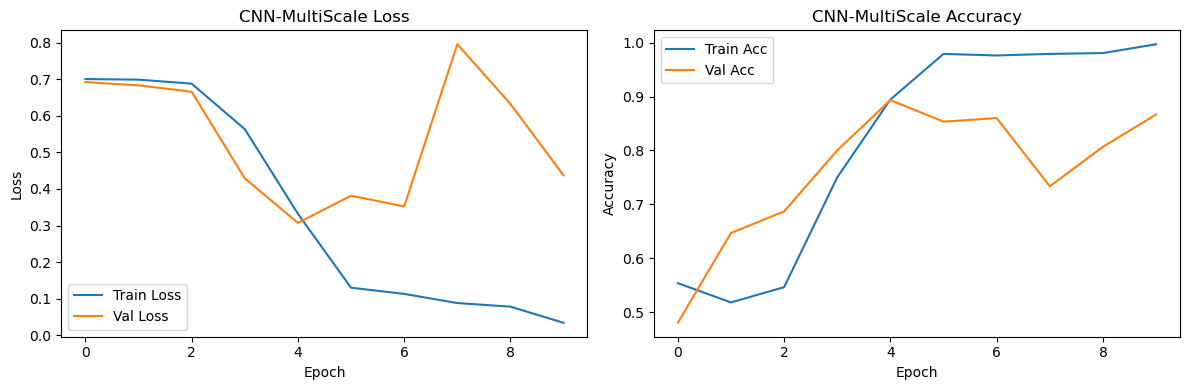


SAMPLE TEST PREDICTIONS (BiLSTM)

Sample 1:
Clause 1: bonus. in addition to the base salary, during the term, executive will be eligible to participate in...
Clause 2: bonus. bonus means an amount equal to the average of the bonuses awarded to executive for each of th...
True Label: 1.0, Predicted: 0.0, Confidence: 0.4823
Status: INCORRECT
------------------------------------------------------------

Sample 2:
Clause 1: bank accounts. schedule 2.25 constitutes a full and complete list of all the bank accounts and safe ...
Clause 2: certain defined terms. as used herein, the following capitalized terms shall have the specified valu...
True Label: 0.0, Predicted: 0.0, Confidence: 0.4822
Status: CORRECT
------------------------------------------------------------

Sample 3:
Clause 1: bank accounts. the custodian shall identify on its books as belonging to the applicable fund cash (i...
Clause 2: books and records. licensee shall keep accurate books and records with respect to the product

,accuracy,precision,recall,f1_score,roc_auc,pr_auc
BiLSTM-Attention,0.50,0.0000,0.0000,0.0000,0.7038,0.7302
CNN-MultiScale,0.86,0.9655,0.7467,0.8421,0.9476,0.9542


In [24]:
# Run main once
main()

# Now you have:
# bilstm_metrics, cnn_metrics, bilstm_preds, cnn_preds, all_labels
# You can do a tabular comparison:
metrics_df = pd.DataFrame({
    "BiLSTM-Attention": bilstm_metrics,
    "CNN-MultiScale": cnn_metrics
}).T
display(metrics_df.round(4))
